In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
import pickle
%matplotlib inline

from stage1_util import calibrate, cal_undistort, load_camera_cal, corners_unwarp, pipeline

## Image Caliberation, Undistortion, and Prespective transformation

In [2]:
mtx, dist = load_camera_cal() #calibrate('camera_cal/calibration*.jpg')

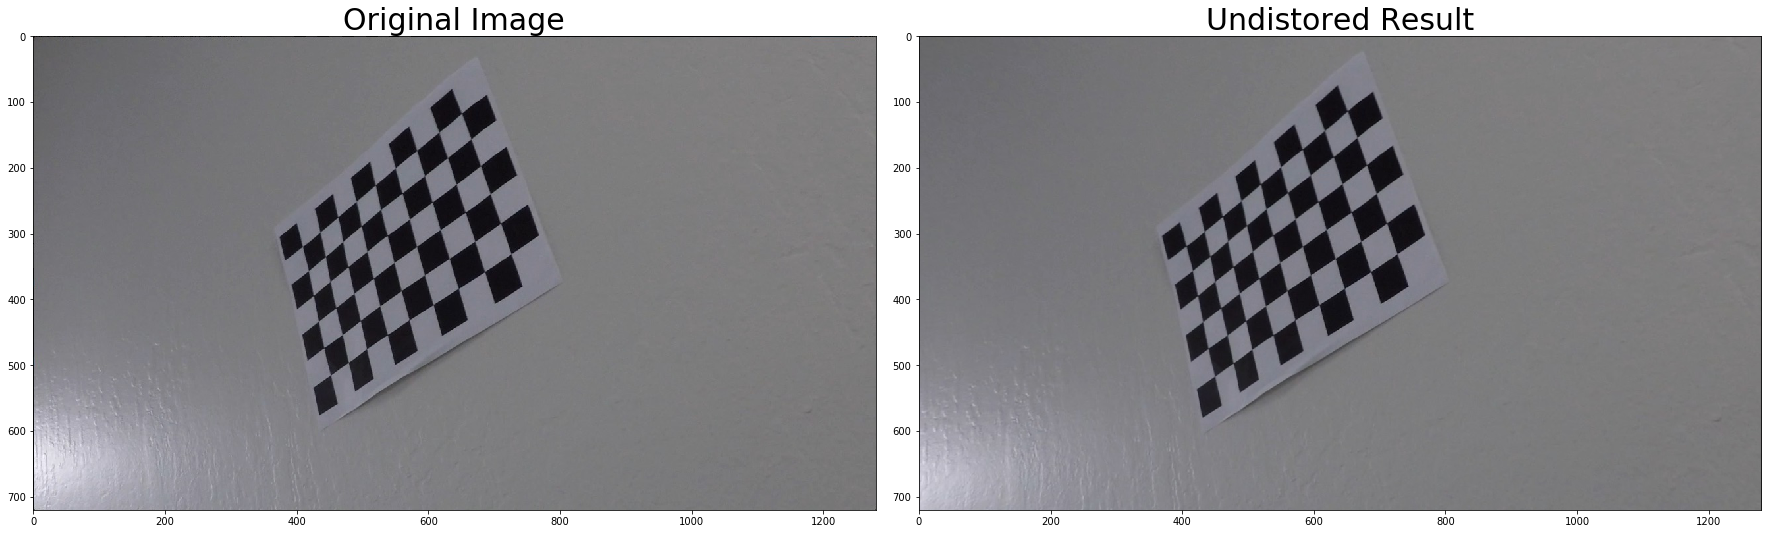

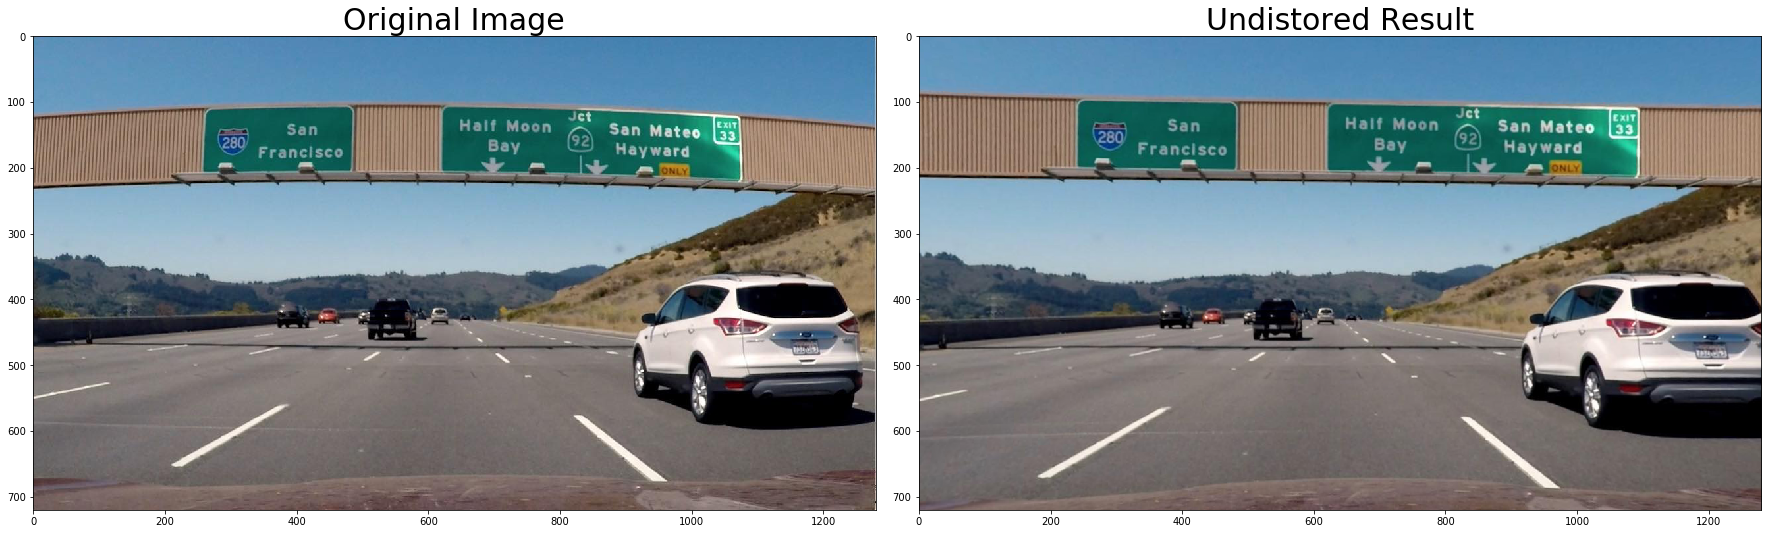

In [3]:
imag_cal_ex = plt.imread('camera_cal/calibration13.jpg')
und_img_cal_ex = cal_undistort(imag_cal_ex, mtx, dist)

img_test_ex = plt.imread('test_images/signs_vehicles_xygrad.png')
und_img_test_ex = cal_undistort(img_test_ex, mtx, dist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(imag_cal_ex)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(und_img_cal_ex)
ax2.set_title('Undistored Result', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_test_ex)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(und_img_test_ex)
ax2.set_title('Undistored Result', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

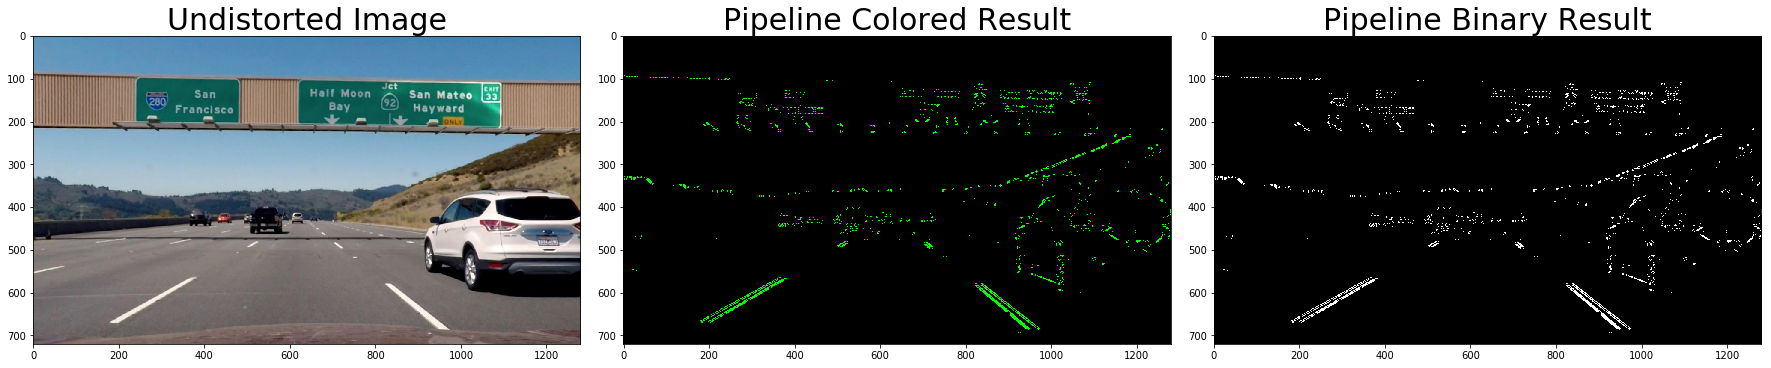

In [4]:
combined, colored = pipeline(und_img_test_ex)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(und_img_test_ex)
ax1.set_title('Undistorted Image', fontsize=30)

ax2.imshow(colored)
ax2.set_title('Pipeline Colored Result', fontsize=30)

ax3.imshow(combined, cmap='gray')
ax3.set_title('Pipeline Binary Result', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


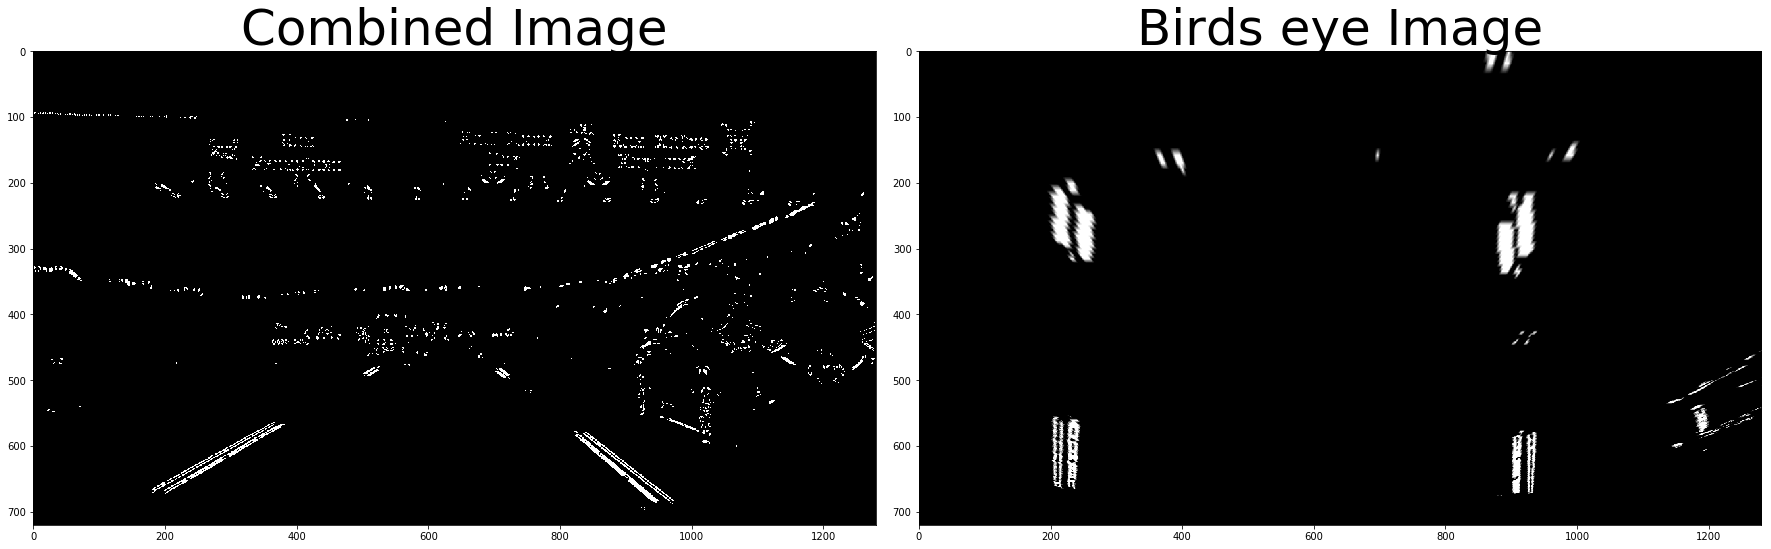

In [5]:
top_down = corners_unwarp(combined, 9, 6, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined, cmap='gray')
ax1.set_title('Combined Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Birds eye Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## sliding window

In [6]:
print(top_down.shape)
print(top_down.shape[0]//2)
print((top_down[top_down.shape[0]//2:,:].shape))
print(np.sum(top_down[top_down.shape[0]//2:,:], axis=0).shape)

(720, 1280)
360
(360, 1280)
(1280,)


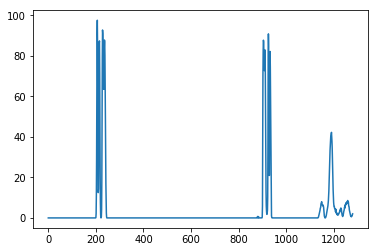

In [7]:

histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
plt.plot(histogram)

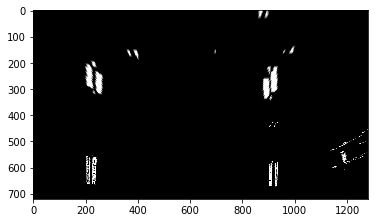

In [8]:
out_img1 = np.uint8(np.dstack((top_down, top_down, top_down))*255)
plt.imshow(out_img1)

In [9]:
midpoint = np.int(histogram.shape[0]/2)
print(midpoint)
leftx_base = np.argmax(histogram[:midpoint])
print(leftx_base, histogram[leftx_base])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(rightx_base, histogram[rightx_base])
print(np.int(top_down.shape[0]/9))

640
206 97.6484375
925 90.9033203125
80


In [10]:
zz = np.array([[1,0.5,0,1],[0,1,1,1]])
nonzerozz = zz.nonzero()
print(nonzerozz[0])
print(nonzerozz[1])
print(zz[0,1])
for ix in range(3):
    print(ix)
xl = ((nonzerozz[0] >= 1) & (nonzerozz[0] <= 3) & (nonzerozz[1] >= 0) & (nonzerozz[1] <= 2)).nonzero()[0]
print(xl)
print(nonzerozz[1][xl])
print(nonzerozz[0][xl])
ll = []
ll.append([1,2])
ll.append([3,4])
print(ll)
ll = np.concatenate(ll)
print(ll)

[0 0 0 1 1 1]
[0 1 3 1 2 3]
0.5
0
1
2
[3 4]
[1 2]
[1 1]
[[1, 2], [3, 4]]
[1 2 3 4]


In [11]:
# Choose the number of sliding windows
nwindows = 8
# Set height of windows
window_height = np.int(top_down.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = top_down.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 40
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [12]:
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = top_down.shape[0] - (window+1)*window_height
    win_y_high = top_down.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    print(win_xleft_low,win_y_low, win_xleft_high, win_y_high)
    print(win_xright_low,win_y_low, win_xright_high, win_y_high)
    # Draw the windows on the visualization image
    cv2.rectangle(out_img1,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img1,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

126 630 286 720
845 630 1005 720
141 540 301 630
836 540 996 630
142 450 302 540
838 450 998 540
142 360 302 450
838 360 998 450
142 270 302 360
839 270 999 360
159 180 319 270
822 180 982 270
147 90 307 180
833 90 993 180
147 0 307 90
896 0 1056 90


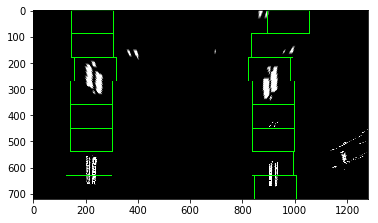

In [13]:
plt.imshow(out_img1)

In [14]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [15]:
print(out_img1[640,334])

[0 0 0]


720


(720, 0)

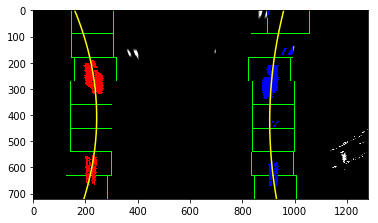

In [16]:
# Generate x and y values for plotting
ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img1[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img1[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
print(len(out_img1[:,:,0]==0))
plt.imshow(out_img1)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [20]:
from  stage2_util import calc_lanes_coeffs_mse, get_lane_lines_field
out2 = np.uint8(np.dstack((top_down, top_down, top_down))*255)
coeff1, coeff2, coeffs_mask = calc_lanes_coeffs_mse (out2)
lane_lines_field = get_lane_lines_field (out2, coeff1, coeff2)
#result = cv2.addWeighted (out2, 1, lane_lines_field, 0.3, 0)
plt.imshow(lane_lines_field, camp='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

ValueError: too many values to unpack (expected 2)